In [1]:
import numpy as np
import networkx as nx
from pyrivet import rivet
from sklearn import datasets
from sklearn.metrics import pairwise_distances
import seaborn as sns
from scipy.cluster import hierarchy
from pyDowker import DowkerComplex
from pyDowker.TwoParameterUtils import discretize_graded_rank, graded_rank_at_value
import gudhi as gd
from gudhi.representations import BettiCurve
import pickle

import matplotlib.pyplot as plt

In [2]:
def sample_annulus_wit_outliers(n, inner_radius,outer_radius, seed, w=0):
    rng = np.random.default_rng(seed=seed)
    angles = rng.uniform(0,2*np.pi,size = n)
    radii = np.sqrt(rng.uniform(inner_radius**2,outer_radius**2,size=n))
    for i in range(n):
        rand = rng.uniform(0,1)
        if rand <= w:
            radii[i] = np.sqrt(rng.uniform(0,inner_radius**2))

    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    return np.array([x,y]).T

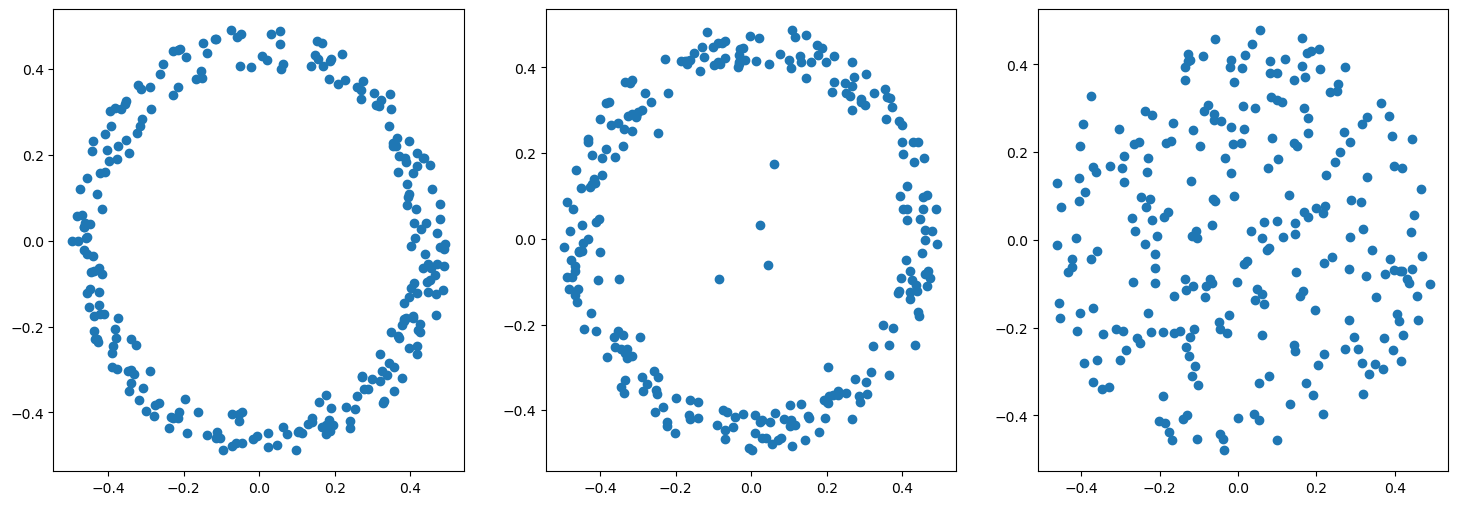

In [3]:
X = sample_annulus_wit_outliers(256,0.4,0.5,0)
Y = sample_annulus_wit_outliers(256,0.4,0.5,1,0.05)
Z = sample_annulus_wit_outliers(256,0,0.5,2,0)

np.savetxt("output/clean_annulus_points",X)
np.savetxt("output/noisy_annulus_points",Y)

f,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(X[:,0],X[:,1])
ax[1].scatter(Y[:,0],Y[:,1])
ax[2].scatter(Z[:,0],Z[:,1])


plt.savefig("output/noisy_annuli.pdf", bbox_inches='tight', pad_inches=0)


plt.show()

m_max = 50

DX = pairwise_distances(X)
DY = pairwise_distances(Y)
DZ = pairwise_distances(Z)

In [ ]:
closed_mncX = DowkerComplex(DX)
closed_bifiX = closed_mncX.create_rivet_bifiltration_cpp(max_dimension=2, m_max=m_max)
closed_bettiX = rivet.betti_file(closed_bifiX.name,homology=1,x=m_max,y=m_max)


closed_mncY = DowkerComplex(DY)
closed_bifiY = closed_mncY.create_rivet_bifiltration_cpp(max_dimension=2, m_max=m_max)
closed_bettiY = rivet.betti_file(closed_bifiY.name,homology=1,x=m_max,y=m_max)

closed_mncZ = DowkerComplex(DZ)
closed_bifiZ = closed_mncZ.create_rivet_bifiltration_cpp(max_dimension=2, m_max=m_max)
closed_bettiZ = rivet.betti_file(closed_bifiZ.name,homology=1,x=m_max,y=m_max)


output = open('output/{}_neighbor_bettiX.pkl'.format(m_max), 'wb')
pickle.dump(closed_bettiX, output)
output.close()
output = open('output/{}_neighbor_bettiY.pkl'.format(m_max), 'wb')
pickle.dump(closed_bettiY, output)
output.close()
output = open('output/{}_neighbor_bettiZ.pkl'.format(m_max), 'wb')
pickle.dump(closed_bettiZ, output)
output.close()

In [ ]:
deg_betti_X = rivet.betti(rivet.PointCloud(X), homology=1,x=m_max,y=m_max)
deg_betti_Y = rivet.betti(rivet.PointCloud(Y), homology=1,x=m_max,y=m_max)
deg_betti_Z = rivet.betti(rivet.PointCloud(Z), homology=1,x=m_max,y=m_max)

output = open('output/{}_deg_neighbor_bettiX.pkl'.format(m_max), 'wb')
pickle.dump(deg_betti_X, output)
output.close()
output = open('output/{}_deg_neighbor_bettiY.pkl'.format(m_max), 'wb')
pickle.dump(deg_betti_Y, output)
output.close()
output = open('output/{}_deg_neighbor_bettiZ.pkl'.format(m_max), 'wb')
pickle.dump(deg_betti_Z, output)
output.close()


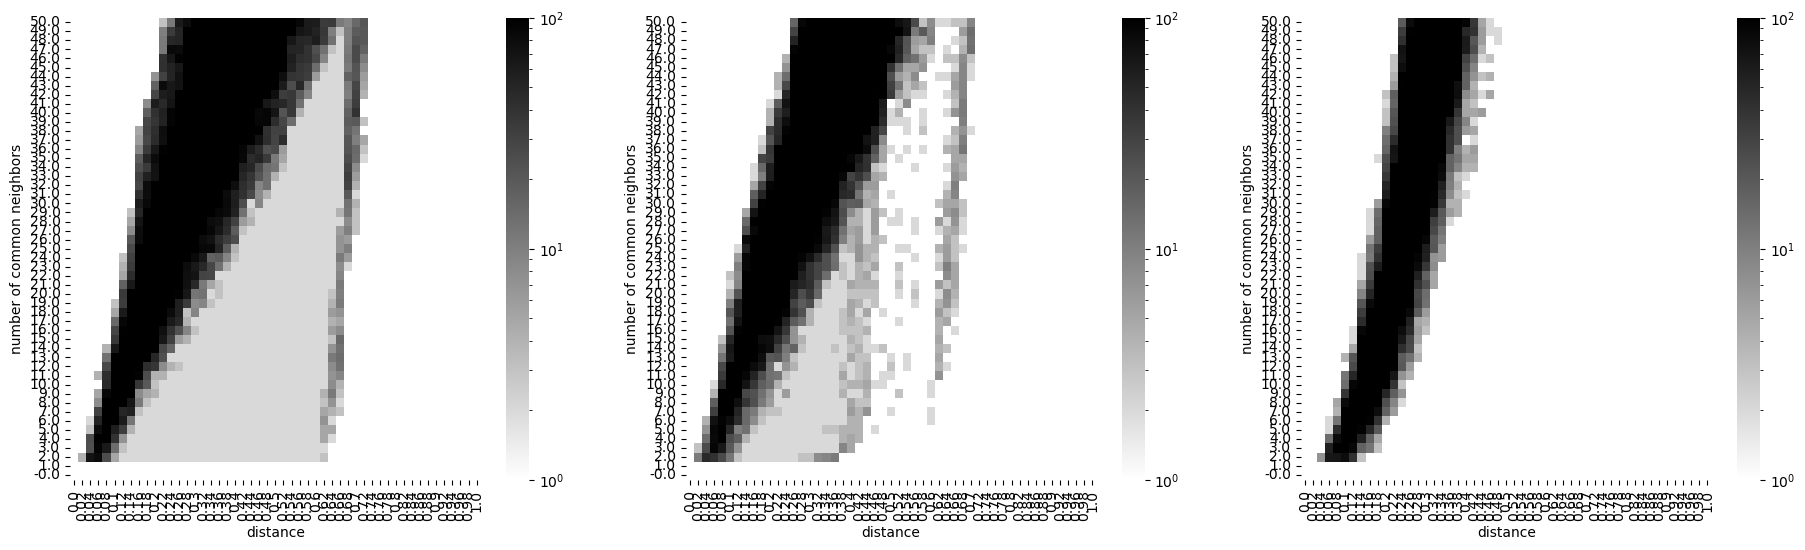

In [4]:
from matplotlib.colors import LogNorm
x_grid = np.linspace(0,1,m_max+1)
y_grid = np.linspace(-m_max,0,m_max+1)



pkl_file = open('output/{}_neighbor_bettiX.pkl'.format(m_max), 'rb')
bettiX = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/{}_neighbor_bettiY.pkl'.format(m_max), 'rb')
bettiY = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/{}_neighbor_bettiZ.pkl'.format(m_max), 'rb')
bettiZ = pickle.load(pkl_file)
pkl_file.close()



gridbettiX = discretize_graded_rank(bettiX,x_grid,y_grid)
gridbettiY = discretize_graded_rank(bettiY,x_grid,y_grid)
gridbettiZ = discretize_graded_rank(bettiZ,x_grid,y_grid)

v_min = None
v_max = 100
lnorm = LogNorm(vmin=v_min,vmax=v_max)
colormap = sns.color_palette("binary", as_cmap=True)

f,ax = plt.subplots(1,3,figsize=(22.5,6))
sns.heatmap(1+gridbettiX, norm = lnorm, rasterized=True, linewidths=0, ax=ax[0], annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2), cmap=colormap)
#ax[0].invert_yaxis()
sns.heatmap(1+gridbettiY, norm = lnorm,rasterized=True, linewidths=0, ax=ax[1],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2),cmap=colormap)
#ax[1].invert_yaxis()

sns.heatmap(1+gridbettiZ, norm = lnorm,rasterized=True, linewidths=0, ax=ax[2],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2), cmap=colormap)
#ax[2].invert_yaxis()

for a in ax:
    a.set_ylabel("number of common neighbors")
    a.set_xlabel("distance")
plt.grid(False)
plt.savefig("output/noisy_annulus_{}neighbors.pdf".format(m_max), bbox_inches='tight', pad_inches=0)
plt.show()


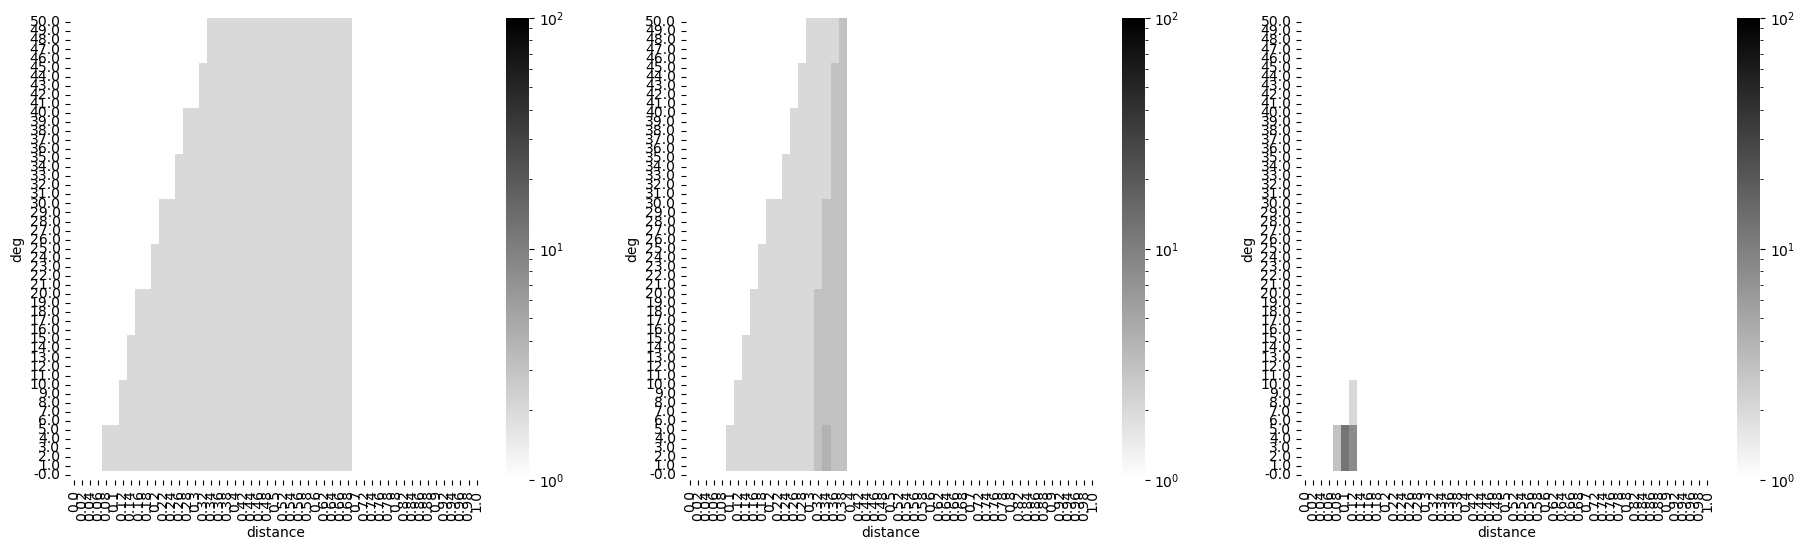

In [6]:
pkl_file = open('output/{}_deg_neighbor_bettiX.pkl'.format(m_max), 'rb')
deg_betti_X = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/{}_deg_neighbor_bettiY.pkl'.format(m_max), 'rb')
deg_betti_Y = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/{}_deg_neighbor_bettiZ.pkl'.format(m_max), 'rb')
deg_betti_Z = pickle.load(pkl_file)
pkl_file.close()


deg_gridbettiX = discretize_graded_rank(deg_betti_X,y_grid,x_grid)
deg_gridbettiY = discretize_graded_rank(deg_betti_Y,y_grid,x_grid)
deg_gridbettiZ = discretize_graded_rank(deg_betti_Z,y_grid,x_grid)



f,ax = plt.subplots(1,3,figsize=(22.5,6))
sns.heatmap(1+deg_gridbettiX.T, norm = lnorm,rasterized=True, ax=ax[0], annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2), cmap=colormap)
#ax[0].invert_yaxis()
sns.heatmap(1+deg_gridbettiY.T, norm = lnorm,rasterized=True, ax=ax[1],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2),  cmap=colormap)
#ax[1].invert_yaxis()
sns.heatmap(1+deg_gridbettiZ.T, norm = lnorm,rasterized=True, ax=ax[2],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2),  cmap=colormap)
#ax[2].invert_yaxis()
#ax[0].imshow(deg_betti_X.graded_rank)
for a in ax:
    a.set_ylabel("deg")
    a.set_xlabel("distance")

plt.savefig("noisy_annulus_{}deg.pdf".format(m_max), bbox_inches='tight', pad_inches=0)
plt.show()


In [53]:
### Fixed Grid
coords = np.linspace(-0.45,0.45,10)
G =np.array([(i,j) for i in coords for j in coords])
GX = pairwise_distances(G,X)
GY = pairwise_distances(G,Y)
GZ = pairwise_distances(G,Z)

grid_DowkerX = DowkerComplex(GX)
grid_Dowker_bifiX = grid_DowkerX.create_rivet_bifiltration_cpp(max_dimension=2, m_max=m_max)
grid_Dowker_bettiX = rivet.betti_file(grid_Dowker_bifiX.name,homology=1,x=m_max,y=m_max)


grid_DowkerY = DowkerComplex(GY)
grid_Dowker_bifiY = grid_DowkerY.create_rivet_bifiltration_cpp(max_dimension=2, m_max=m_max)
grid_Dowker_bettiY = rivet.betti_file(grid_Dowker_bifiY.name,homology=1,x=m_max,y=m_max)

grid_DowkerZ = DowkerComplex(GZ)
grid_Dowker_bifiZ = grid_DowkerZ.create_rivet_bifiltration_cpp(max_dimension=2, m_max=m_max)
grid_Dowker_bettiZ = rivet.betti_file(grid_Dowker_bifiZ.name,homology=1,x=m_max,y=m_max)


output = open('output/grid_Dowker_{}_bettiX.pkl'.format(m_max), 'wb')
pickle.dump(grid_Dowker_bettiX, output)
output.close()
output = open('output/grid_Dowker_{}_bettiY.pkl'.format(m_max), 'wb')
pickle.dump(grid_Dowker_bettiY, output)
output.close()
output = open('output/grid_Dowker_{}_bettiZ.pkl'.format(m_max), 'wb')
pickle.dump(grid_Dowker_bettiZ, output)
output.close()


m-Neighbor bifiltered complex construction using distance matrix from tmp_dist_, max dimension = 2, m_max = 50
saving RIVET format...
m-Neighbor bifiltered complex construction using distance matrix from tmp_dist_, max dimension = 2, m_max = 50
saving RIVET format...
m-Neighbor bifiltered complex construction using distance matrix from tmp_dist_, max dimension = 2, m_max = 50
saving RIVET format...


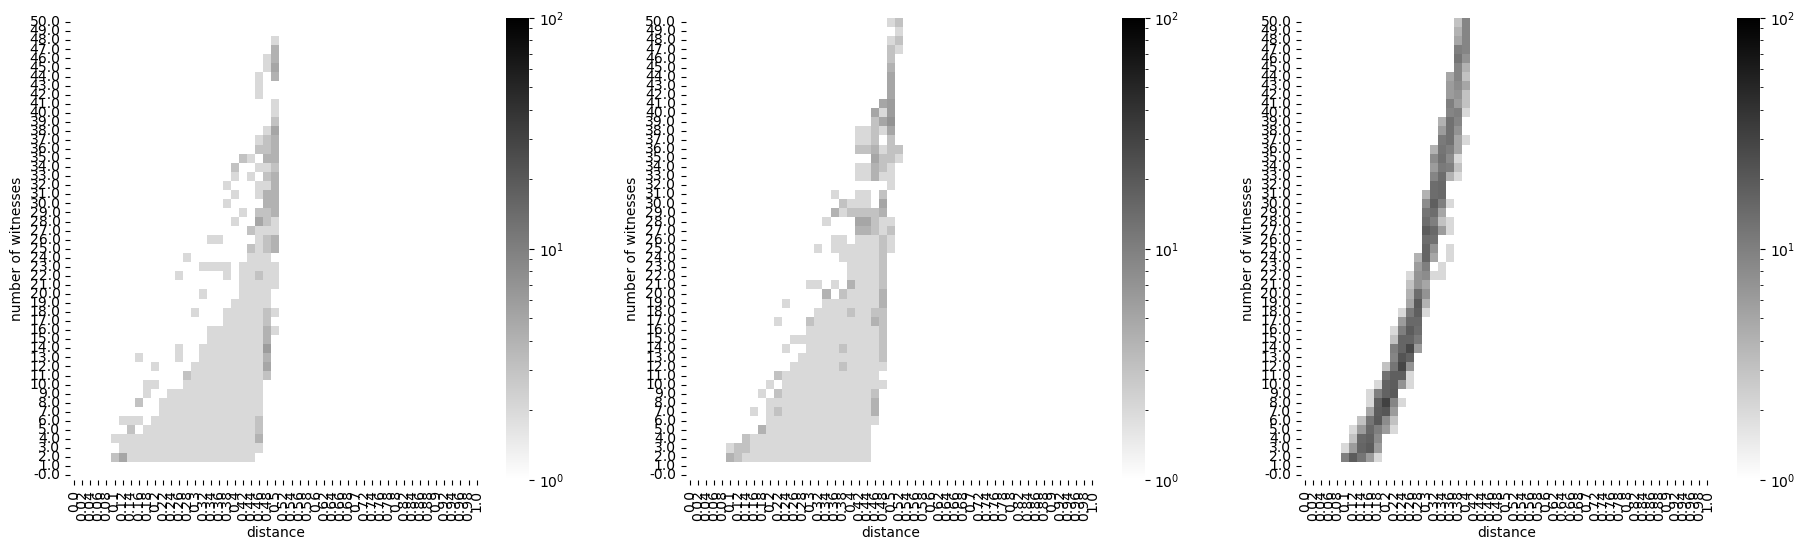

In [54]:
pkl_file = open('output/grid_Dowker_{}_bettiX.pkl'.format(m_max), 'rb')
closed_bettiX = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/grid_Dowker_{}_bettiY.pkl'.format(m_max), 'rb')
closed_bettiY = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/grid_Dowker_{}_bettiZ.pkl'.format(m_max), 'rb')
closed_bettiZ = pickle.load(pkl_file)
pkl_file.close()

grid_Dowker_gridbettiX = discretize_graded_rank(grid_Dowker_bettiX,x_grid,y_grid)
grid_Dowker_gridbettiY = discretize_graded_rank(grid_Dowker_bettiY,x_grid,y_grid)
grid_Dowker_gridbettiZ = discretize_graded_rank(grid_Dowker_bettiZ,x_grid,y_grid)



f,ax = plt.subplots(1,3,figsize=(22.5,6))
sns.heatmap(1+grid_Dowker_gridbettiX, norm = lnorm,rasterized=True, ax=ax[0], annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2),cmap=colormap)
#ax[0].invert_yaxis()
sns.heatmap(1+grid_Dowker_gridbettiY, norm = lnorm,rasterized=True, ax=ax[1],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2), cmap=colormap)
#ax[1].invert_yaxis()
sns.heatmap(1+grid_Dowker_gridbettiZ, norm = lnorm,rasterized=True, ax=ax[2],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2),  cmap=colormap)
#ax[2].invert_yaxis()

for a in ax:
    a.set_ylabel("number of witnesses")
    a.set_xlabel("distance")

plt.savefig("output/noisy_annulus_{}_grid_Dowker.pdf".format(m_max), bbox_inches='tight', pad_inches=0)
plt.show()

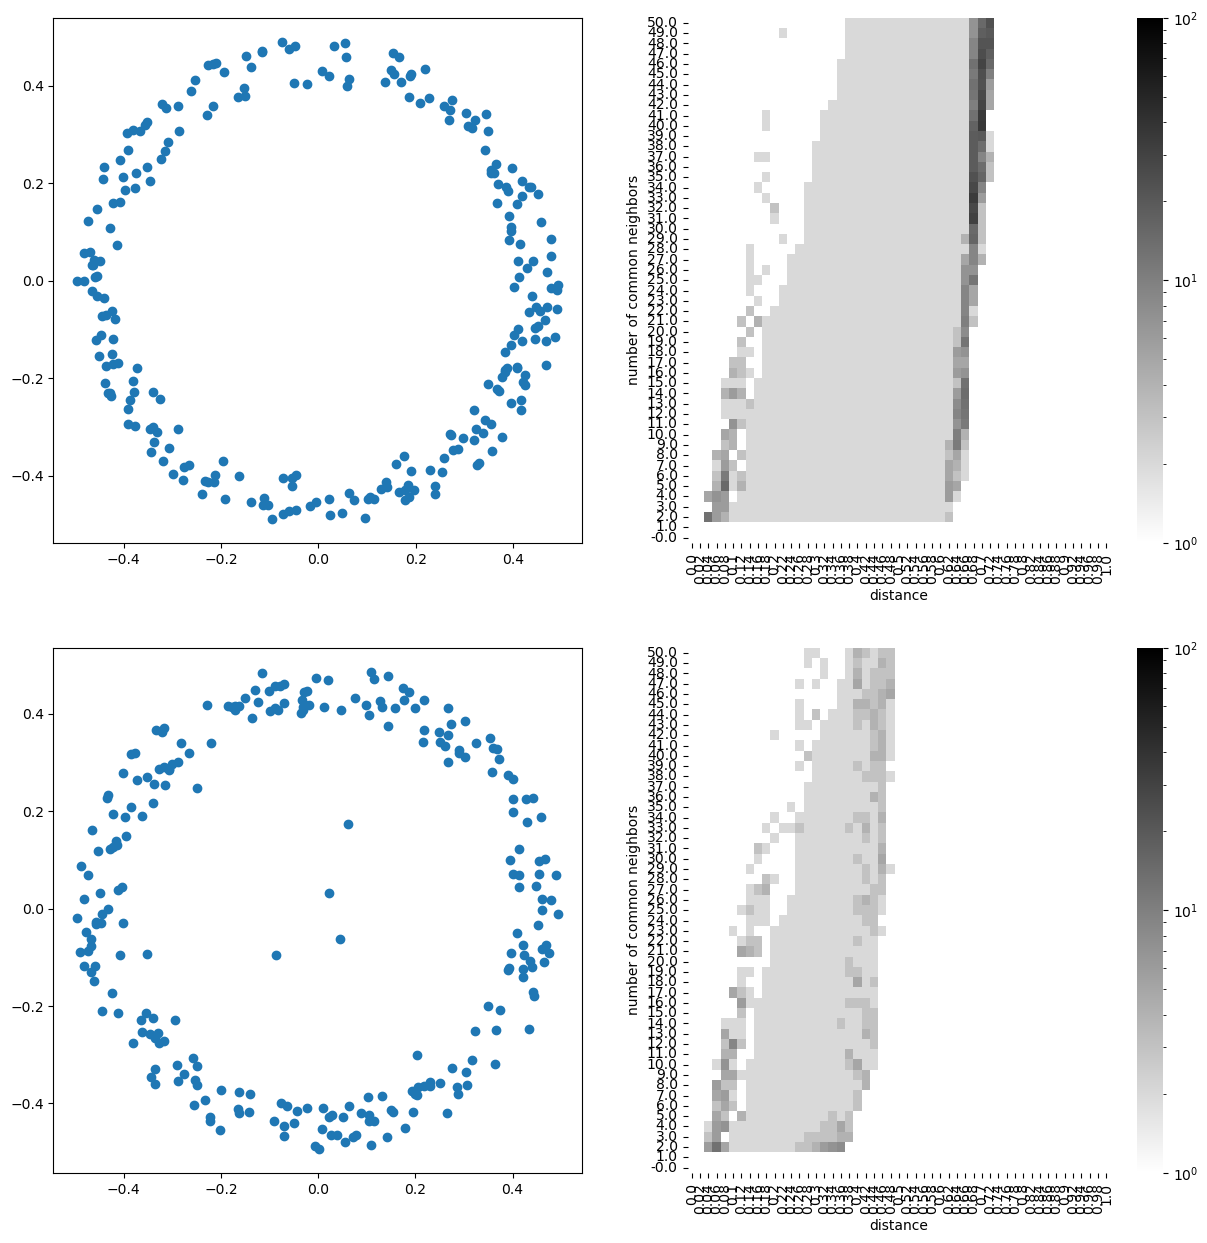

In [25]:
pkl_file = open('output/{}_neighbor_bettiX.pkl'.format(m_max), 'rb')
closed_bettiX = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('output/{}_neighbor_bettiY.pkl'.format(m_max), 'rb')
closed_bettiY = pickle.load(pkl_file)
pkl_file.close()


closed_gridbettiX = discretize_graded_rank(closed_bettiX,x_grid,y_grid)
closed_gridbettiY = discretize_graded_rank(closed_bettiY,x_grid,y_grid)

f,ax = plt.subplots(2,2, figsize = (15,15))

ax[0,0].scatter(X[:,0],X[:,1])
ax[1,0].scatter(Y[:,0],Y[:,1])

sns.heatmap(1+closed_gridbettiX, norm = lnorm,rasterized=True, ax=ax[0,1], annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2),cmap=colormap)
sns.heatmap(1+closed_gridbettiY, norm = lnorm,rasterized=True, ax=ax[1,1],annot=False, yticklabels=-y_grid, xticklabels=np.round(x_grid,2), cmap=colormap)
for i in range(2):
    ax[i,1].set_ylabel("number of common neighbors")
    ax[i,1].set_xlabel("distance")

plt.savefig('output/noisy_annulus_hf_for_beamer.pdf')
plt.show()